In [1]:
!nvidia-smi

Fri Aug 14 05:18:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget -O data.tgz https://gntuedutw-my.sharepoint.com/:u:/g/personal/b07901020_g_ntu_edu_tw/EY6n-UwrWhVLibJcYPUpn60BvHPqkurEo2CqA1uDaBpYpg?download=1
!tar zxvf data.tgz

--2020-08-14 05:18:07--  https://gntuedutw-my.sharepoint.com/:u:/g/personal/b07901020_g_ntu_edu_tw/EY6n-UwrWhVLibJcYPUpn60BvHPqkurEo2CqA1uDaBpYpg?download=1
Resolving gntuedutw-my.sharepoint.com (gntuedutw-my.sharepoint.com)... 40.108.228.30
Connecting to gntuedutw-my.sharepoint.com (gntuedutw-my.sharepoint.com)|40.108.228.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/b07901020_g_ntu_edu_tw/Documents/Lecture%20Notes,%202019%20Summer%20Interns/info_data/data.tgz?&originalPath=aHR0cHM6Ly9nbnR1ZWR1dHctbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvYjA3OTAxMDIwX2dfbnR1X2VkdV90dy9FWTZuLVV3cldoVkxpYkpjWVBVcG42MEJ2SFBxa3VyRW8yQ3FBMXVEYUJwWXBnP3J0aW1lPXJNTjRiaEZBMkVn [following]
--2020-08-14 05:18:08--  https://gntuedutw-my.sharepoint.com/personal/b07901020_g_ntu_edu_tw/Documents/Lecture%20Notes,%202019%20Summer%20Interns/info_data/data.tgz?&originalPath=aHR0cHM6Ly9nbnR1ZWR1dHctbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvYjA3OTAxMDIwX2dfbnR1X2VkdV90dy

In [3]:
import pandas as pd
import re
import os
import time
import random
import numpy as np
import copy

try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import SmoothingFunction
from google.colab import drive
import pickle

import spacy

nlp = spacy.load("en_core_web_sm")
smoothie = SmoothingFunction()
from nltk.translate.bleu_score import corpus_bleu

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [4]:
tf.__version__

'2.3.0'

In [5]:
drive_root = 'data'

### Creating the dataset of word problems

*Please add the correct path to load the data file*

In [6]:
import pandas as pd
import pickle
import numpy as np
import os
import json

data_json = pd.read_json('questions.json')
# print(data_json['lEquations'].apply(lambda x: '\n'.join(x)))
# dataframe.apply 給自己實現的函數傳遞參數
data_final = pd.DataFrame({'Question':list(data_json['sQuestion'].values), 'Equation':list(data_json['lEquations'].apply(lambda x: '\n'.join(x)).values)})   # lambda 後面接的東西就相當於函式的參數
data_final = data_final[:250].sample(frac=1)

with open('data_final.pkl','wb') as f:
  pickle.dump(data_final, f)

with open('data_final.pkl', 'rb') as f:
  df = pickle.load(f)

In [7]:
df.shape

(250, 2)

In [8]:
df.head()

,Question,Equation
31,A semi truck travels on a paved road for 2 hou...,(2.0*paved_speed)+(3.0*dirt_speed)=200.0\npave...
173,"On a test containing 120 questions , the final...",(1.0*right)-(0.25*wrong)=100.0\nright+wrong=120.0
44,A car rented for 29 dollars per day plus 0.08 ...,29.0+(0.08*miles_driven)=46.12
59,Find two numbers whose sum is 106 and whose di...,number+other_number=106.0\nnumber-other_number...
184,One number exceeds another by 10 and their sum...,larger+smaller=34.0\nlarger=10.0+smaller


In [9]:
input_exps = list(df['Question'].values)

In [10]:
def convert_eqn(eqn):
  '''
  Add a space between every character in the equation string.
  Eg: 'x = 23 + 88' becomes 'x =  2 3 + 8 8'
  '''
  variables = re.findall(r'[a-zA-Z_]+', eqn)
  # variables = [re.sub('_', ' ', var) for var in variables]
  element = list(re.sub(r'[a-zA-Z_]+', 'X', eqn))
  eqn = ' '.join(element)
  i = 0
  while re.search('X', eqn) :
      eqn = eqn.replace('X', variables[i], 1)
      i += 1
  return eqn

In [11]:
target_exps = list(df['Equation'].apply(lambda x: convert_eqn(x)).values)
print(df['Equation'])

31     (2.0*paved_speed)+(3.0*dirt_speed)=200.0\npave...
173    (1.0*right)-(0.25*wrong)=100.0\nright+wrong=120.0
44                        29.0+(0.08*miles_driven)=46.12
59     number+other_number=106.0\nnumber-other_number...
184             larger+smaller=34.0\nlarger=10.0+smaller
                             ...                        
179                           65.0+(0.4*miles)=0.6*miles
30     (3.0*donuts)+(4.0*coffees)=4.91\n(5.0*donuts)+...
6      (12.0*adult_tickets)+(5.0*children_tickets)=51...
148    (3.0*three_point)+(4.0*four_point)=100.0\nthre...
94               larger+smaller=13.0\nlarger-smaller=3.0
Name: Equation, Length: 250, dtype: object


In [12]:
# Input: Word problem
input_exps[:5]

['A semi truck travels on a paved road for 2 hours at an average speed of 20 miles per hour faster than it travels on a dirt road. The time spent on the dirt is 3 hours. If the entire trip is 200 miles , how fast is the truck traveling on the dirt road? ',
 'On a test containing 120 questions , the final score is based on 1 point for each correct answer and 0.25 of a point subtracted for each incorrect answer. Allan answered all of the questions and received a final score of 100 points. How many questions did Allan answer correctly? ',
 'A car rented for 29 dollars per day plus 0.08 dollars per mile. Julia paid 46.12 dollars for a 1-day rental. How far did she drive , in miles? ',
 'Find two numbers whose sum is 106 and whose difference is 64.',
 'One number exceeds another by 10 and their sum is 34. Find the larger number.']

In [13]:
# Target: Equation
target_exps[:5]

['( 2 . 0 * paved_speed ) + ( 3 . 0 * dirt_speed ) = 2 0 0 . 0 \n paved_speed = 2 0 . 0 + dirt_speed',
 '( 1 . 0 * right ) - ( 0 . 2 5 * wrong ) = 1 0 0 . 0 \n right + wrong = 1 2 0 . 0',
 '2 9 . 0 + ( 0 . 0 8 * miles_driven ) = 4 6 . 1 2',
 'number + other_number = 1 0 6 . 0 \n number - other_number = 6 4 . 0',
 'larger + smaller = 3 4 . 0 \n larger = 1 0 . 0 + smaller']

In [14]:
len(pd.Series(input_exps)), len(pd.Series(input_exps).unique())

(250, 250)

In [15]:
len(pd.Series(target_exps)), len(pd.Series(target_exps).unique())

(250, 249)

### Preprocessing and Tokenizing the Input and Target exps

In [16]:
def preprocess_input(sentence):
  '''
  For the word problem, convert everything to lowercase, add spaces around all
  punctuations and digits, and remove any extra spaces. 
  '''
  sentence = sentence.lower().strip()
  sentence = re.sub(r"([?.!,’])", r" \1 ", sentence)
  sentence = re.sub(r"([0-9])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = sentence.rstrip().strip()
  return sentence

In [17]:
def preprocess_target(sentence):
  '''
  For the equation, convert it to lowercase and remove extra spaces
  '''
  sentence = sentence.lower().strip()
  return sentence

In [18]:
preprocessed_input_exps = list(map(preprocess_input, input_exps))    # map function through 'map', 'preprocess_input is the name of function
preprocessed_target_exps = list(map(preprocess_target, target_exps))

In [19]:
preprocessed_input_exps[:5]

['a semi truck travels on a paved road for 2 hours at an average speed of 2 0 miles per hour faster than it travels on a dirt road . the time spent on the dirt is 3 hours . if the entire trip is 2 0 0 miles , how fast is the truck traveling on the dirt road ?',
 'on a test containing 1 2 0 questions , the final score is based on 1 point for each correct answer and 0 . 2 5 of a point subtracted for each incorrect answer . allan answered all of the questions and received a final score of 1 0 0 points . how many questions did allan answer correctly ?',
 'a car rented for 2 9 dollars per day plus 0 . 0 8 dollars per mile . julia paid 4 6 . 1 2 dollars for a 1 -day rental . how far did she drive , in miles ?',
 'find two numbers whose sum is 1 0 6 and whose difference is 6 4 .',
 'one number exceeds another by 1 0 and their sum is 3 4 . find the larger number .']

In [20]:
preprocessed_target_exps[:5]

['( 2 . 0 * paved_speed ) + ( 3 . 0 * dirt_speed ) = 2 0 0 . 0 \n paved_speed = 2 0 . 0 + dirt_speed',
 '( 1 . 0 * right ) - ( 0 . 2 5 * wrong ) = 1 0 0 . 0 \n right + wrong = 1 2 0 . 0',
 '2 9 . 0 + ( 0 . 0 8 * miles_driven ) = 4 6 . 1 2',
 'number + other_number = 1 0 6 . 0 \n number - other_number = 6 4 . 0',
 'larger + smaller = 3 4 . 0 \n larger = 1 0 . 0 + smaller']

In [21]:
def tokenize(lang):
  '''
  Tokenize the given list of strings and return the tokenized output
  along with the fitted tokenizer.
  '''
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)            # This method creates the vocabulary index based on word frequency, like {'the':1, 'earth':2, .......}
  tensor = lang_tokenizer.texts_to_sequences(lang)
  return tensor, lang_tokenizer

In [22]:
input_tensor, inp_lang_tokenizer = tokenize(preprocessed_input_exps)

In [23]:
len(inp_lang_tokenizer.word_index)

1185

In [24]:
target_tensor, targ_lang_tokenizer = tokenize(preprocessed_target_exps)

In [25]:
old_len = len(targ_lang_tokenizer.word_index)

In [26]:
inp_len = len(inp_lang_tokenizer.word_index)

In [27]:
def append_start_end(x,last_int):
  '''
  Add integers for start and end tokens for input/target exps
  '''
  l = []
  l.append(last_int+1)
  l.extend(x)
  l.append(last_int+2)
  return l

In [28]:
input_tensor_list = [append_start_end(i,len(inp_lang_tokenizer.word_index)) for i in input_tensor]
target_tensor_list = [append_start_end(i,len(targ_lang_tokenizer.word_index)) for i in target_tensor]

In [29]:
# Pad (at the end) all sequences such that they are of equal length
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor_list, padding='post')
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor_list, padding='post')

In [30]:
input_tensor

array([[1186,    7,  744, ...,    0,    0,    0],
       [1186,   41,    7, ...,    0,    0,    0],
       [1186,    7,  135, ...,    0,    0,    0],
       ...,
       [1186,    7,  150, ...,    0,    0,    0],
       [1186,    7, 1183, ...,    0,    0,    0],
       [1186,    3,  128, ...,    0,    0,    0]], dtype=int32)

In [31]:
target_tensor

array([[326,   5,   9, ...,   0,   0,   0],
       [326,   5,   8, ...,   0,   0,   0],
       [326,   9,  17, ...,   0,   0,   0],
       ...,
       [326,   5,   8, ...,   0,   0,   0],
       [326,   5,  12, ...,   0,   0,   0],
       [326,  20,   7, ...,   0,   0,   0]], dtype=int32)

In [32]:
# Here we are increasing the vocabulary size of the target, by adding a
# few extra vocabulary words (which will not actually be used) as otherwise the
# small vocab size causes issues downstream in the network.
keys = [str(i) for i in range(10,51)]
for i,k in enumerate(keys):
  targ_lang_tokenizer.word_index[k]=len(targ_lang_tokenizer.word_index)+i+4

In [33]:
len(targ_lang_tokenizer.word_index)

366

### Create a tf.data dataset

In [34]:
# Creating training and validation sets
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,
                                                                                                target_tensor,
                                                                                                test_size=0.2,
                                                                                                random_state=42)

In [35]:
len(input_tensor_train)

200

In [36]:
len(input_tensor_val)

50

In [37]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 40
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
num_layers = 2
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = len(inp_lang_tokenizer.word_index)+3
target_vocab_size = len(targ_lang_tokenizer.word_index)+3
dropout_rate = 0.0

In [38]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([40, 104]), TensorShape([40, 61]))

### Transformer Model

#### Positional Encoding

In [39]:
# We provide positional information about the data to the model,
# otherwise each sentence will be treated as Bag of Words
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [40]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

#### Masking

In [41]:
# mask all elements are that not words (padding) so that it is not treated as input
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [42]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [43]:
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


#### Attention

In [44]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [45]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

#### Pointwise Feed forward network

In [46]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

#### Encoder Layer

In [47]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # normalize data per feature instead of batch
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):
    # Multi-head attention layer
    attn_output, _ = self.mha(x, x, x, mask) 
    attn_output = self.dropout1(attn_output, training=training)
    # add residual connection to avoid vanishing gradient problem
    out1 = self.layernorm1(x + attn_output)
    
    # Feedforward layer
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    # add residual connection to avoid vanishing gradient problem
    out2 = self.layernorm2(out1 + ffn_output)
    return out2

#### Encoder

In [48]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    # Create encoder layers (count: num_layers)
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x 

#### Decoder Layer

In [49]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    # Masked multihead attention layer (padding + look-ahead)
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    # again add residual connection
    out1 = self.layernorm1(attn1 + x)
    
    # Masked multihead attention layer (only padding)
    # with input from encoder as Key and Value, and input from previous layer as Query
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training=training)
    # again add residual connection
    out2 = self.layernorm2(attn2 + out1)
    
    # Feedforward layer
    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    # again add residual connection
    out3 = self.layernorm3(ffn_output + out2)
    return out3, attn_weights_block1, attn_weights_block2

#### Decoder

In [50]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
     
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    # Create decoder layers (count: num_layers)
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    
    x += self.pos_encoding[:,:seq_len,:]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      # store attenion weights, they can be used to visualize while translating
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    return x, attention_weights

#### Transformer

In [51]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    # Pass the input to the encoder
    enc_output = self.encoder(inp, training, enc_padding_mask)
    
    # Pass the encoder output to the decoder
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    # Pass the decoder output to the last linear layer
    final_output = self.final_layer(dec_output)
    
    return final_output, attention_weights

#### Optimizer and Loss

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [53]:
learning_rate = CustomSchedule(d_model)

# Adam optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [54]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [55]:
def loss_function(real, pred):
  # Apply a mask to paddings (0)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [56]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [57]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [58]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Decoder padding mask
  dec_padding_mask = create_padding_mask(inp)
  
  # Look ahead mask (for hiding the rest of the sequence in the 1st decoder attention layer)
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

### Checkpoints

In [59]:
!rm -rf 'data/ADL Project'

In [60]:
checkpoint_dir = os.path.join(drive_root, "ADL Project/checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "training_checkpoints/akshata_transfomer")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)


checkpoint = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

Checkpoints directory is data/ADL Project/checkpoints/training_checkpoints/akshata_transfomer
Creating a checkpoints directory


In [61]:
latest = ckpt_manager.latest_checkpoint
latest

In [62]:
if latest:
  epoch_num = int(latest.split('/')[-1].split('-')[-1])
  checkpoint.restore(latest)
  print ('Latest checkpoint restored!!')
else:
  epoch_num = 0

In [63]:
epoch_num

0

#### Training

In [64]:
MAX_LENGTH = 40

In [65]:
# set up a dataset
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_evalue = dataset_val.batch(1, drop_remainder=False)
dataset_val = dataset_val.batch(50, drop_remainder=False)   # 當 dataset 少於 batchsize 的情形下刪除最後一批資料

In [66]:
BUFFER_SIZE

200

In [67]:
from multiprocessing import Pool

def PredictIdx2Word(tensor_idxs, require_idx=False):
  pre_sentence = []
  tensor_idxs = tf.squeeze(tensor_idxs, axis=0)
  for (idx, i) in enumerate(tensor_idxs.numpy()):
    if i in [0, old_len+2] :    # end 
      break  
    if (i < len(targ_lang_tokenizer.word_index) and i not in [0,old_len+1,old_len+2]):
      pre_sentence.append(targ_lang_tokenizer.index_word[i])
  if require_idx:
    return pre_sentence, idx
  else:
    return pre_sentence

def TarIdx2Word(tensor_idxs):
  target_sentence = ''
  tensor_idxs = tf.squeeze(tensor_idxs, axis=0)
  for i in tensor_idxs.numpy():
    if i not in [0,old_len+1,old_len+2]:
      target_sentence += (targ_lang_tokenizer.index_word[i] + ' ')
  target_sentence = target_sentence.split(' ')[:-1]
  return target_sentence

def InpIdx2Sec(tensor_idxs, require_idx=False):
  inp_sentence = ''
  tensor_idxs = tf.squeeze(tensor_idxs, axis=0)
  for (idx, i) in enumerate(tensor_idxs.numpy()):
    if i in [0, inp_len+2]:
      break
    if i not in [0,inp_len+1,inp_len+2]:
      inp_sentence += (inp_lang_tokenizer.index_word[i] + ' ')
  if require_idx:
    return inp_sentence[:-1], idx
  else:
    return inp_sentence

In [68]:
def calAnc(y_true, y_pred):

  for i in range(len(y_true)):
    for j in range(len(y_true[i])):
      y_true[i][j] = targ_lang_tokenizer.word_index[y_true[i][j]]
  for i in range(len(y_pred)):
    for j in range(len(y_pred[i])):
      y_pred[i][j] = targ_lang_tokenizer.word_index[y_pred[i][j]]

  y_true = tf.keras.preprocessing.sequence.pad_sequences(y_true, padding='post', value=3)
  y_pred = tf.keras.preprocessing.sequence.pad_sequences(y_pred, padding='post', value=3)
  print(y_true[0])
  print(y_pred[0])
  if y_true.shape[1] < y_pred.shape[1]:
    y_pred = y_pred[:, :y_true.shape[1]]
  else:
    y_true = y_true[:, :y_pred.shape[1]]
  
  table = np.equal(y_true, y_pred)
  # print(table[0])
  table = np.multiply.reduce(table, axis=-1)
  # print(np.count_nonzero(table>0), len(table))

  return np.count_nonzero(table>0), len(table)

In [69]:
def maskValidate(v_data, calLoss=False):
  y_true = []
  y_pred = []
  for (batch, (inp, tar)) in enumerate(v_data):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, _ = transformer(inp, tar_inp, 
                                False, 
                                enc_padding_mask, 
                                combined_mask, 
                                dec_padding_mask)
    if calLoss:
      loss = loss_function(tar_real, predictions)
      val_loss(loss)

    predicted_max = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    list_predicted_max = tf.split(predicted_max, num_or_size_splits=len(predicted_max), axis=0)
    list_target = tf.split(tar, num_or_size_splits=len(tar), axis=0)

    with Pool(processes=8) as pool:
      list_tar_sentence = pool.map(TarIdx2Word, list_target)
      list_predicted_sentence = pool.map(PredictIdx2Word, list_predicted_max)
    y_true.append(list_tar_sentence)
    y_pred.append(list_predicted_sentence)
  y_true = [val for sublist in y_true for val in sublist]
  y_pred = [val for sublist in y_pred for val in sublist]
  return y_true, y_pred

In [70]:
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  # train_accuracy(tar_real, predictions)

def train_process(dataset, epoch=-1):
  # 訓練模型 inp -> question, tar -> equation
  dataset.shuffle(BUFFER_SIZE)
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)
    
    print ('\r', 'Train [{:3d}] Batch [{:4d}] loss {:.4f} perplexity {:.4f}'.format(
        epoch + 1, batch, train_loss.result(), np.exp(train_loss.result())), end='')

def val_process(dataset, dataset_val, epoch=-1, evalue=False):
  
  train_y_true, train_y_pred = maskValidate(dataset)
  val_y_true, val_y_pred = maskValidate(dataset_val, calLoss=True)

  if (evalue == True):
    train_anc, train_total = calAnc(copy.deepcopy(train_y_true), copy.deepcopy(train_y_pred))
    val_anc, val_total = calAnc(copy.deepcopy(val_y_true), copy.deepcopy(val_y_pred))
    if (epoch == -1):
      return val_y_true, val_y_pred, val_anc, val_total
    else:
      print('\nEpoch [{:3d}]  train_loss {:.4f}, train_bleu {:.4f}, train_acc {:.4f}, val_loss {:.4f}, val_bleu {:.4f}, val_acc {:.4f}'.format(
                                                                epoch + 1,
                                                                float(train_loss.result()),
                                                                corpus_bleu(train_y_true, train_y_pred, smoothing_function=smoothie.method4),
                                                                float(train_anc)/train_total,
                                                                float(val_loss.result()),
                                                                corpus_bleu(val_y_true, val_y_pred, smoothing_function=smoothie.method4),
                                                                float(val_anc)/val_total,
                                                                ))
  elif not evalue:
    print('\nEpoch [{:3d}]             train_loss {:.4f}, val_loss {:.4f}'.format(epoch + 1, float(train_loss.result()), float(val_loss.result())))

In [71]:
EPOCHS = 200

for epoch in range(epoch_num, EPOCHS):
  start = time.time()
  train_loss.reset_states()
  val_loss.reset_states()
  train_accuracy.reset_states()
  # 訓練模型
  train_process(dataset, epoch=epoch)
  # 檢驗模型
  if (epoch+1) % 50 == 0:
    val_process(dataset, dataset_val, epoch=epoch, evalue=True)
    if (epoch+1) % 50 == 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

 Train [ 50] Batch [   4] loss 1.2531 perplexity 3.5011[  5  14   2   1   3 172   6   7   5   9   2   1   3 173   6   4   8   9
  16   2  17   9  11   5  12   2   1   3 172   6   7   5  15   2   1   3
 173   6   4   8  12  12   2  15  17   3   3   3   3   3   3   3   3   3
   3   3   3   3   3]
[5 9 2 1 3 6 6 7 5 9 2 1 3 6 6 4 9 9 2 2 1 2 2 5 9 2 1 2 4 4 4 5 9 2 1 2 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[  5   5  14   2   1   3   1   2   1   8   6   3 196   6   7   5   5   8
  13   2   1   3   1   2   1   8   6   3 197   6   4   8   9   2   1   3
   1   2   1   8   3  10   1   2   1  11 196   7 197   4  10   1   2   1
   3   3   3   3   3]
[5 9 9 2 1 3 6 3 1 3 3 4 3 6 4 5 9 9 8 2 1 2 1 2 1 2 8 4 4 4 4 8 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]

Epoch [ 50]  train_loss 1.2531, train_bleu 0.2643, train_acc 0.0000, val_loss 1.3192, val_bleu 0.2672, val_acc 0.0000
Saving checkpoint for epoch 50 at data/ADL Project/checkpoints/training_checkpoints/akshata_transf

### Evaluate

In [72]:
# For single sentence
def val_translate(inp, tar, plot=''):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  # predictions.shape == (1, seq_len, vocab_size)
  predictions, attention_weights = transformer(inp, tar_inp, 
                              False, 
                              enc_padding_mask, 
                              combined_mask, 
                              dec_padding_mask)
  predicted_max = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
  input_sentence, input_idx = InpIdx2Sec(inp ,require_idx=True)
  tar_sentence = TarIdx2Word(tar)
  predicted_sentence, idx = PredictIdx2Word(predicted_max, require_idx=True)
  print('Input: {}'.format(input_sentence), '  input_idx:', input_idx)
  print('Target translation: {}'.format(' '.join(tar_sentence)))
  print('Predicted translation: {}'.format(' '.join(predicted_sentence)))
  if plot:
    plot_attention_weights(attention_weights, input_sentence, tf.squeeze(predicted_max, axis=0), plot, idx, input_idx)

In [73]:
def evaluate(inp_sentence):
  start_token = [len(inp_lang_tokenizer.word_index)+1]
  end_token = [len(inp_lang_tokenizer.word_index)+2]
  
  # inp sentence is the word problem, hence adding the start and end token
  inp_sentence = start_token + [inp_lang_tokenizer.word_index[i] for i in preprocess_input(inp_sentence).split(' ')]+end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # start with equation's start token
  decoder_input = [old_len+1]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :] 
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == old_len+2:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)
  return tf.squeeze(output, axis=0), attention_weights

In [74]:
def plot_attention_weights(attention, sentence, result, layer, idx=-1, input_idx=-1):
  fig = plt.figure(figsize=(24, 12))
  sentence = preprocess_input(sentence)
  attention = tf.squeeze(attention[layer], axis=0)
  if idx!=-1:
    print('idx: {}, input_idx: {}'.format(idx, input_idx), '  attention.shape: ', attention[0][:idx, :input_idx+1].shape)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    if input_idx != -1:
      ax.matshow(attention[head][:idx, :input_idx+1], cmap='viridis')
    else:
      ax.matshow(attention[head][:idx, :], cmap='viridis')
    
    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence.split(' '))+2))

    align_seq = []
    for i in list(result.numpy()):
      if i in [0, old_len+2]:
        break
      if i < len(targ_lang_tokenizer.word_index) and i not in [0,old_len+1,old_len+2]:
        align_seq.append(targ_lang_tokenizer.index_word[i])

    ax.set_yticks(range(len(align_seq)+3))
    
    
    ax.set_ylim(len(align_seq), -0.5)

    ax.set_xticklabels(
        ['<start>']+sentence.split(' ')+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels(align_seq, fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [75]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  # print('result',list(result.numpy()))

  # use the result tokens to convert prediction into a list of characters
  # (not inclusing padding, start and end tokens)
  predicted_sentence = TarIdx2Word(tf.expand_dims(result, axis=0))  
  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(' '.join(predicted_sentence)))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

### Get Accuracy and Corpus BLEU

In [76]:
y_true, y_pred, acc_cnt, total = val_process(dataset, dataset_val, evalue=True)

[ 5  8  2  1  3 81  6 18  5  1  2  9 10  3 82  6  4  8  1  1  2  1 11 81
  7 82  4  8  9  1  2  1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3]
[ 5  8  2  1  3 81  6 18  5  1  2  9 10  3 82  6  4  8  1  1  2  1 11 81
  7 82  4  8  9  1  2  1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3]
[  5 178   7 179   6   3   9   2   1   4   9  14   2   1  11   5 178  18
 179   6   3  13   2   1   4   9  14   2   1   3   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3
   3   3   3   3   3]
[ 5  9  7  9  9  4  2  2  1  4  9 17  2  1 11  9  9  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3]


In [77]:
print('Corpus BLEU score of the model: ', corpus_bleu(y_true, y_pred, smoothing_function=smoothie.method4))

Corpus BLEU score of the model:  0.29520900049446114


In [78]:
print('Accuracy of the model: ', acc_cnt/total)

Accuracy of the model:  0.0


### Attention Weights on Training Set

In [79]:
inp, tar = random.choice(list(dataset))
idx = random.choice(range(40))
inp = tf.expand_dims(inp[idx], axis=0)
tar = tf.expand_dims(tar[idx], axis=0)

Target translation:  1 6 0 . 0 + ( 7 . 0 * week ) = 2 1 0 . 0 + ( 5 . 0 * week )
Input: you have 1 6 0 dollars and save 7 dollars per week . your friend has 2 1 0 dollars and saves 5 dollars per week . after how many weeks will each of you have saved the same amount of money ? 
Predicted translation: 1 6 0 . 0 + ( 7 . 0 * week ) = 2 1 0 . 0 + ( 5 . 0 * week )


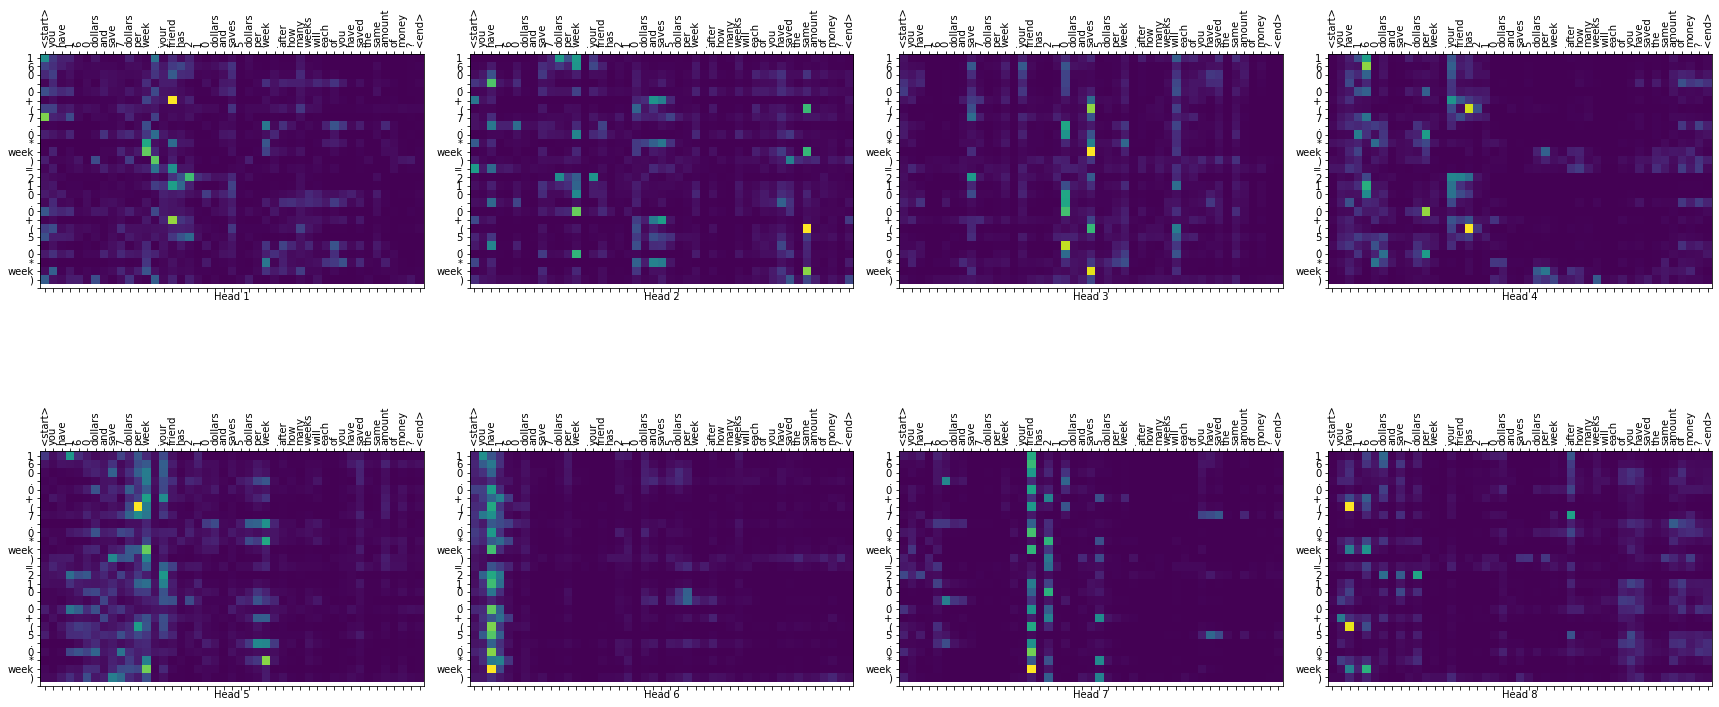

In [80]:
check_str = InpIdx2Sec(inp)
print('Target translation: ', ' '.join(TarIdx2Word(tar)))
translate(check_str, plot='decoder_layer2_block2')                  

Input: you have 1 6 0 dollars and save 7 dollars per week . your friend has 2 1 0 dollars and saves 5 dollars per week . after how many weeks will each of you have saved the same amount of money ?   input_idx: 44
Target translation: 1 6 0 . 0 + ( 7 . 0 * week ) = 2 1 0 . 0 + ( 5 . 0 * week )
Predicted translation: 1 6 0 . 0 + ( 7 . 0 * week ) = 2 1 0 . 0 + ( 5 . 0 * week )
idx: 27, input_idx: 44   attention.shape:  (27, 45)


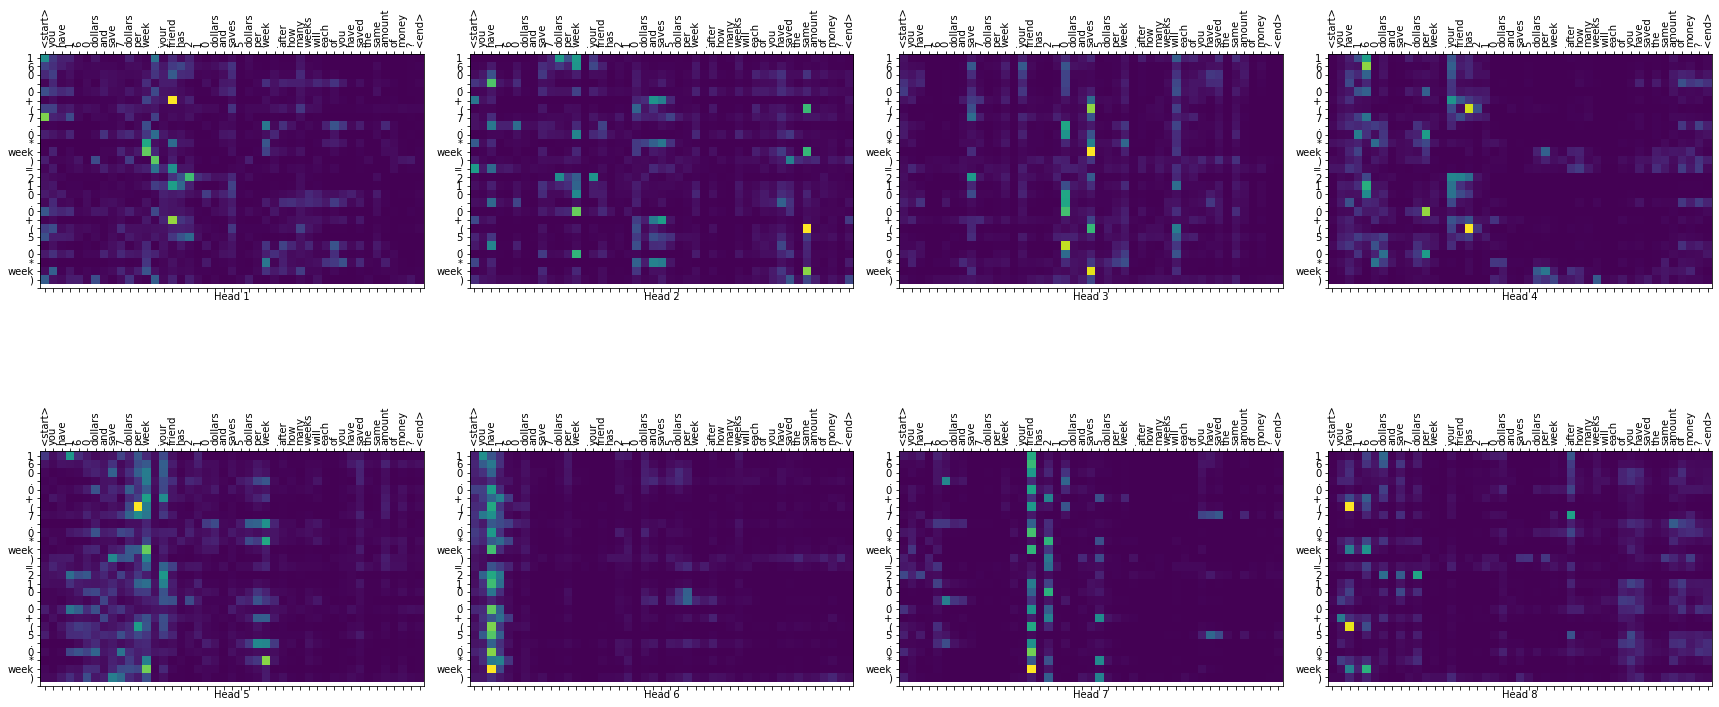

In [81]:
val_translate(inp, tar, 'decoder_layer2_block2')

#### Translation

In [82]:
check_str = ' '.join([inp_lang_tokenizer.index_word[i] for i in input_tensor_val[32] if i not in [0,
                                                                                                  len(inp_lang_tokenizer.word_index)+1,
                                                                                                  len(inp_lang_tokenizer.word_index)+2]])

In [83]:
check_str

'find the amount of 6 percent acid solution and the amount of a 1 4 percent acid solution that pat should combine to prepare 5 0 cubic-centimeters of 1 2 percent solution .'

Input: find the amount of 6 percent acid solution and the amount of a 1 4 percent acid solution that pat should combine to prepare 5 0 cubic-centimeters of 1 2 percent solution .
Predicted translation: 9 5 . 0 * + ( 1 . 0 * 0 . 0 1 * minutes ) = 1 2 9 . 0


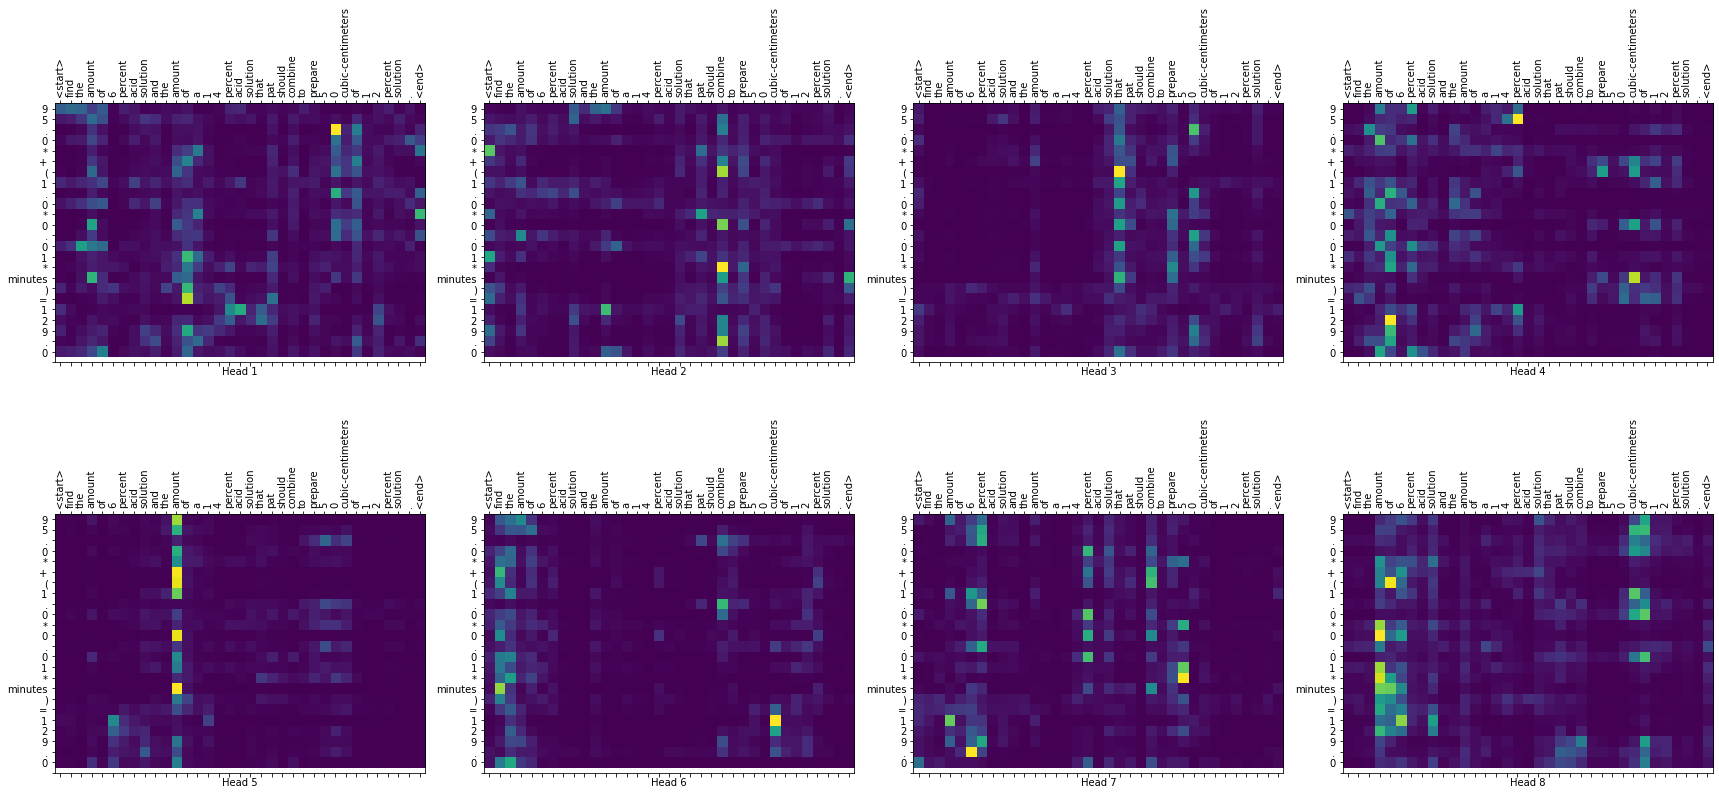

In [84]:
translate(check_str, plot='decoder_layer2_block2')

In [85]:
check_str = ' '.join([inp_lang_tokenizer.index_word[i] for i in input_tensor_val[0] if i not in [0,
                                                                                                  len(inp_lang_tokenizer.word_index)+1,
                                                                                                  len(inp_lang_tokenizer.word_index)+2]])
check_str

'the probability that san francisco plays in the next super bowl is nine times the probability that they do not play in the next super bowl . the probability that san francisco plays in the next super bowl plus the probability that they do not play is 1 . what is the probability that san francisco plays in the next super bowl ?'

Input: the probability that san francisco plays in the next super bowl is nine times the probability that they do not play in the next super bowl . the probability that san francisco plays in the next super bowl plus the probability that they do not play is 1 . what is the probability that san francisco plays in the next super bowl ?
Predicted translation: ( 2 . 0 * cows ) + ( 2 . 0 * first ) = 2 0 . 0 
 4 . 0 
 hours = 
 hours = 3 . 0


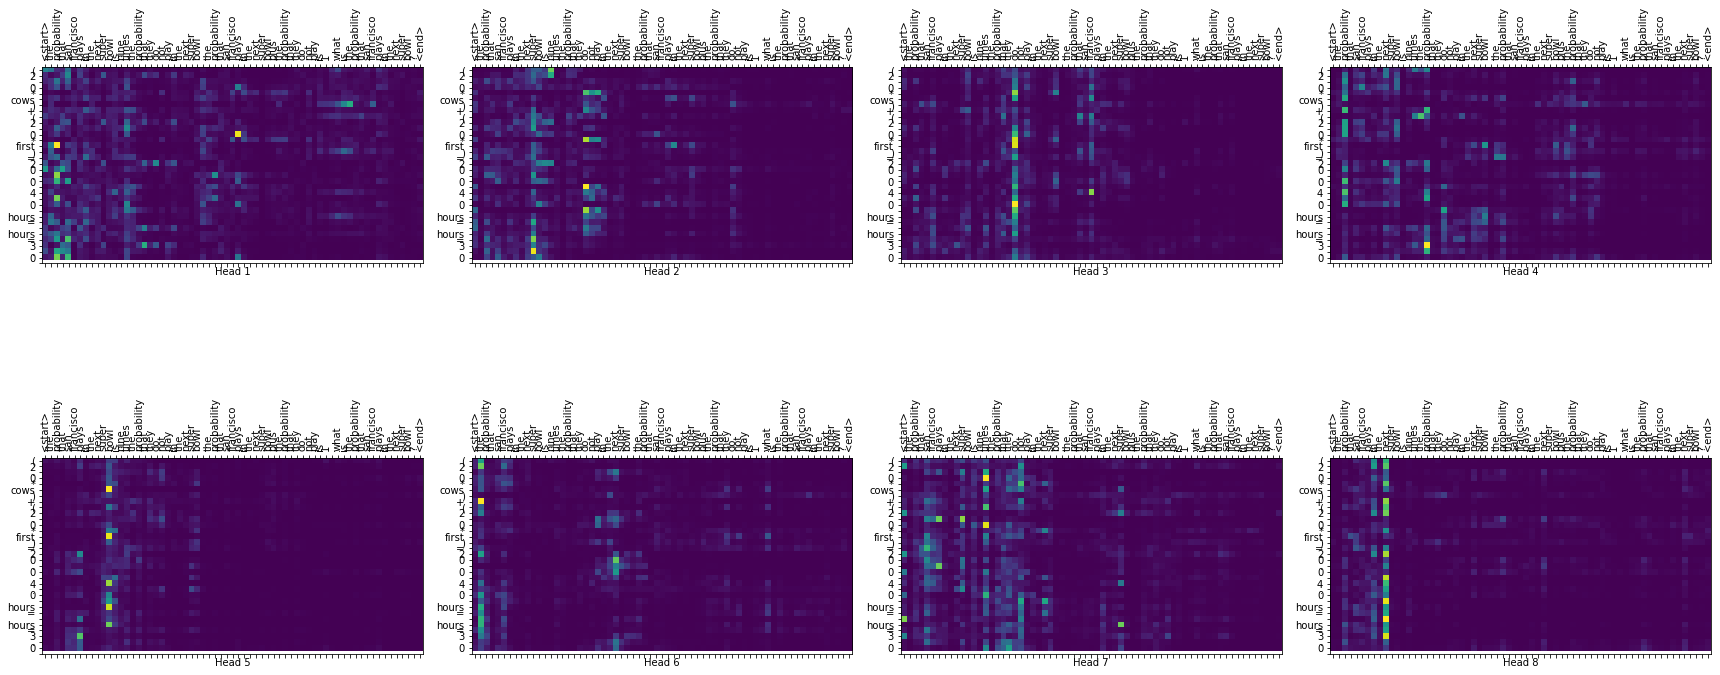

In [86]:
translate(check_str,
          plot='decoder_layer2_block2')

In [87]:
check_str = ' '.join([inp_lang_tokenizer.index_word[i] for i in input_tensor_val[32] if i not in [0,
                                                                                                  len(inp_lang_tokenizer.word_index)+1,
                                                                                                  len(inp_lang_tokenizer.word_index)+2]])
check_str

'find the amount of 6 percent acid solution and the amount of a 1 4 percent acid solution that pat should combine to prepare 5 0 cubic-centimeters of 1 2 percent solution .'

Input: find the amount of 6 percent acid solution and the amount of a 1 4 percent acid solution that pat should combine to prepare 5 0 cubic-centimeters of 1 2 percent solution .
Predicted translation: 9 5 . 0 * + ( 1 . 0 * 0 . 0 1 * minutes ) = 1 2 9 . 0


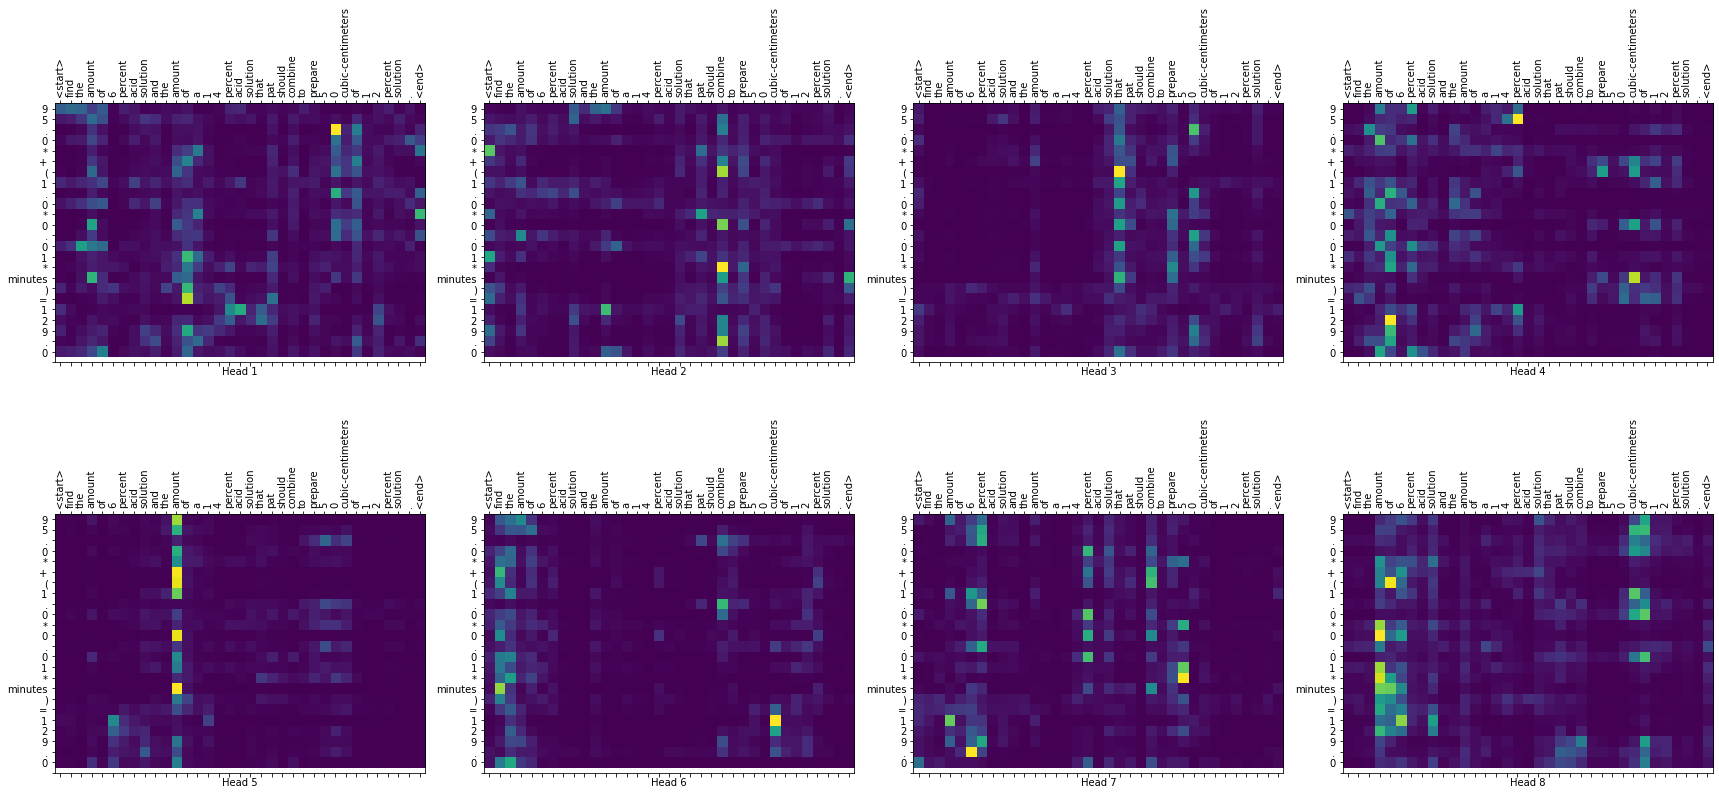

In [88]:
translate(check_str,
          plot='decoder_layer2_block2')

In [89]:
translate("Jerry had 135 pens. John took 19 from him. How many pens Jerry have left?",
          plot='decoder_layer2_block2')

KeyError: ignored

### Conclusions

We see that the scores for the transformer model are much higher than the Bidirectional Seq2Seq model, and that the attention plots are also better (all the layers and heads) than the previous model. This indicates that this model performs better on our data than the Seq2Seq model. BUt we can see that it has still not been able to learn which words to give proper attention to while deciding the operator to use. 
Moreover, the issue of the dataset not being diverse enough still remains, and this model does not perform very well on questions that do not match the rough format of the questions in the data. 

Sources:
1. https://web.stanford.edu/class/cs224n/reports/custom/15843468.pdf
2. https://www.tensorflow.org/tutorials/text/transformer#top_of_page